In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('../..')
from src import utils

In [2]:
DATA        = Path('data')
RAW         = DATA/'raw'
INTERIM     = DATA/'interim'
PROCESSED   = DATA/'processed'
SUBMISSIONS = DATA/'submissions'

In [3]:
from src.utils import get_weeks
# week_labels = get_weeks(day_from=20160104, num_weeks=121)[52:]
# week_labels = get_weeks(day_from=20160104, num_weeks=121)[96:]
week_labels = get_weeks(day_from=20160104, num_weeks=121)[104:]

In [4]:
print(week_labels)

[20180101, 20180108, 20180115, 20180122, 20180129, 20180205, 20180212, 20180219, 20180226, 20180305, 20180312, 20180319, 20180326, 20180402, 20180409, 20180416, 20180423]


In [5]:
%%time
train = pd.DataFrame()
for name in week_labels[:-1]:
    train = pd.concat([train, pd.read_feather(PROCESSED/f'SVD_17-18_72f/week_{name}_SVD_diffscount.feather')])

CPU times: user 4min 6s, sys: 1min 14s, total: 5min 21s
Wall time: 2min 43s


In [6]:
test = pd.read_feather(PROCESSED/f'SVD_17-18_72f/week_{week_labels[-1]}_SVD_diffscount.feather')

## Fill nan

In [7]:
nan_cols = ['Subsector', 'IndustrySector', 'IndustrySubgroup', 'MarketIssue']

In [9]:
# %%time
# # fill nulls
# for w in weeks:
#     w.fillna({x: '-999' for x in nan_cols}, inplace=True)

In [8]:
train = weeks

In [9]:
%%time
train.fillna({x: '-999' for x in nan_cols}, inplace=True)
test.fillna({x: '-999' for x in nan_cols}, inplace=True)

CPU times: user 13 s, sys: 4.24 s, total: 17.3 s
Wall time: 8.21 s


## Model

In [10]:
cat_cols = ['BuySell', 'Sector', 'Subsector', 'Region_x', 'Country', 
            'TickerIdx', 'Seniority', 'Currency', 'ActivityGroup', 
            'Region_y', 'Activity', 'RiskCaptain', 'Owner', 
            'IndustrySector', 'IndustrySubgroup', 'MarketIssue', 'CouponType']

In [11]:
id_cols = ['TradeDateKey', 'CustomerIdx', 'IsinIdx']
target_col = 'CustomerInterest'
pred_col = 'PredictionIdx'

In [12]:
# columns = list(weeks[0].drop(id_cols + [target_col], axis=1))
# cat_indices = [i for i, col in enumerate(columns) if col in cat_cols]

In [13]:
columns = list(train.drop(id_cols + [target_col], axis=1))
cat_indices = [i for i, col in enumerate(columns) if col in cat_cols]

In [14]:
cat_indices

[0, 45, 46, 47, 48, 49, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 64]

In [15]:
from src.utils import run_model, alert
from catboost import CatBoostClassifier
metric_names = ['auc']

In [18]:
# %%time
# test = weeks[-1]
# weeks = pd.concat(weeks[:-1])
# train = weeks

In [16]:
%%time
y_train = train[target_col]
train.drop(id_cols + [target_col], axis=1, inplace=True)
X_train = train

CPU times: user 2.7 s, sys: 1.08 s, total: 3.78 s
Wall time: 3.75 s


In [17]:
%%time
model = CatBoostClassifier(iterations=1000, eval_metric='AUC')
model.fit(X_train, y_train, cat_features=cat_indices)

0:	learn: 0.7260509	total: 10.5s	remaining: 2h 54m 26s
1:	learn: 0.7418263	total: 20.2s	remaining: 2h 48m 21s
2:	learn: 0.7513586	total: 30.2s	remaining: 2h 47m 19s
3:	learn: 0.7528034	total: 39.9s	remaining: 2h 45m 46s
4:	learn: 0.7547539	total: 49.8s	remaining: 2h 45m 3s
5:	learn: 0.7547038	total: 59.2s	remaining: 2h 43m 19s
6:	learn: 0.7547865	total: 1m 9s	remaining: 2h 44m 39s
7:	learn: 0.7565183	total: 1m 19s	remaining: 2h 44m 7s
8:	learn: 0.7561271	total: 1m 29s	remaining: 2h 44m 3s
9:	learn: 0.7560029	total: 1m 39s	remaining: 2h 43m 32s
10:	learn: 0.7584705	total: 1m 49s	remaining: 2h 43m 23s
11:	learn: 0.7586165	total: 1m 58s	remaining: 2h 42m 47s
12:	learn: 0.7581342	total: 2m 8s	remaining: 2h 42m 23s
13:	learn: 0.7592963	total: 2m 18s	remaining: 2h 42m 5s
14:	learn: 0.7602461	total: 2m 28s	remaining: 2h 42m 1s
15:	learn: 0.7608411	total: 2m 38s	remaining: 2h 42m 6s
16:	learn: 0.7607947	total: 2m 48s	remaining: 2h 42m 11s
17:	learn: 0.7624318	total: 2m 58s	remaining: 2h 42m 21

In [23]:
test.shape

(484758, 73)

In [24]:
X_test = test.drop(id_cols + [target_col, pred_col], axis=1)
# assert list(X_train.columns) == list(X_test.columns)

In [25]:
y_test = model.predict_proba(X_test)[:,1]

In [ ]:
# %%time
# X_test = test.drop(id_cols + [target_col, pred_col], axis=1)
# assert list(X_train.columns) == list(X_test.columns)
# y_test, _, train_res, model = run_model(
#             CatBoostClassifier(iterations=1000, eval_metric='AUC'),
#             X_train, y_train, None, None, X_test,
#             metric_names, None, 
#             params_desc='iterations=1000',
#             dataset_desc='NMF_diffcounts', 
#             early_stopping_rounds=None, cat_indices=cat_indices)

CatBoostClassifier 

0:	learn: 0.6654384	total: 16.3s	remaining: 4h 30m 45s
1:	learn: 0.7202211	total: 33.1s	remaining: 4h 35m 35s
2:	learn: 0.7222674	total: 48.7s	remaining: 4h 29m 57s
3:	learn: 0.7191410	total: 1m 4s	remaining: 4h 27m 18s
4:	learn: 0.7228564	total: 1m 20s	remaining: 4h 26m 37s
5:	learn: 0.7286108	total: 1m 36s	remaining: 4h 25m 11s
6:	learn: 0.7288837	total: 1m 52s	remaining: 4h 26m 1s
7:	learn: 0.7390810	total: 2m 9s	remaining: 4h 27m 20s
8:	learn: 0.7391342	total: 2m 25s	remaining: 4h 26m 47s
9:	learn: 0.7399110	total: 2m 40s	remaining: 4h 25m 18s
10:	learn: 0.7396333	total: 2m 56s	remaining: 4h 24m 58s
11:	learn: 0.7390016	total: 3m 12s	remaining: 4h 23m 57s
12:	learn: 0.7417968	total: 3m 28s	remaining: 4h 23m 39s
13:	learn: 0.7414737	total: 3m 45s	remaining: 4h 24m 38s
14:	learn: 0.7453840	total: 4m 1s	remaining: 4h 24m 23s
15:	learn: 0.7447459	total: 4m 18s	remaining: 4h 24m 29s
16:	learn: 0.7481705	total: 4m 34s	remaining: 4h 24m 49s
17:	learn: 0.7471192	total:

In [26]:
test[target_col] = y_test

## Submission

In [27]:
submission = pd.read_csv(RAW/'sample_submission.csv', low_memory=False)
submission = pd.merge(submission[['PredictionIdx']], test[['PredictionIdx', target_col]], 
                      how='left', on='PredictionIdx')

In [28]:
submission[target_col].describe()

count    4.847580e+05
mean     2.150286e-02
std      3.096028e-02
min      1.457058e-15
25%      6.326308e-03
50%      1.325565e-02
75%      2.553393e-02
max      9.466601e-01
Name: CustomerInterest, dtype: float64

In [29]:
submission.head()

,PredictionIdx,CustomerInterest
0,a1e0d80784,0.007475
1,c2cc6cc2a8,0.035994
2,a8e94f6344,0.003436
3,758bae1e35,0.001078
4,02ab378ee8,0.002094


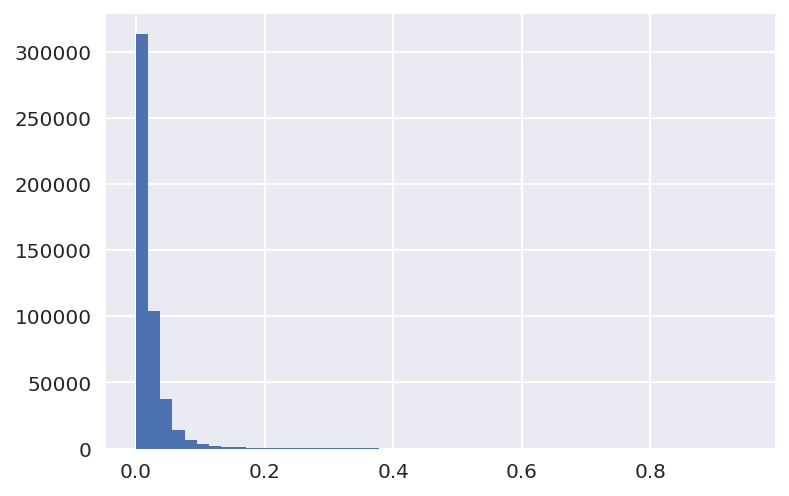

In [30]:
submission[target_col].hist(bins=50)

In [31]:
submission.to_csv(SUBMISSIONS/'RA02-22-catboost_2018_SVD_diffscounts.csv', index=False)

## Feature importance

In [34]:
model.get_feature_importance()

In [ ]:
feature_score = pd.DataFrame(list(zip(one_hot.dtypes.index, model.get_feature_importance(Pool(one_hot, label=y, cat_features=categorical_features_indices)))),
                columns=['Feature','Score'])

In [36]:
model.save_model(str(INTERIM/'catboost_model'))

In [37]:
m = CatBoostClassifier(iterations=1000, eval_metric='AUC')

In [38]:
m.load_model(str(INTERIM/'catboost_model'))

In [43]:
m.tree_count_

1000